In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
sns.set(style="ticks")

# Two-Body Radioactive Decay Model

### i.e. constant $\lambda$ SIR Model

In [2]:
# The suspectibles 
def suspectibles(t, Gamma=2, Lambda=1, S0=1):
    return S0*np.exp(-Lambda*t)

# The infected
def infected(t, Gamma=2, Lambda=1, S0=1):
    return S0*(Lambda/(Gamma - Lambda))*(np.exp(-Lambda*t) - np.exp(-Gamma*t))

# The recovered
def recovered(t, Gamma=2, Lambda=1, S0=1):
    return S0*(1 + (Lambda*np.exp(-Gamma*t) - Gamma*np.exp(-Lambda*t))/(Gamma-Lambda))

In [3]:
t = np.linspace(0,12,366)

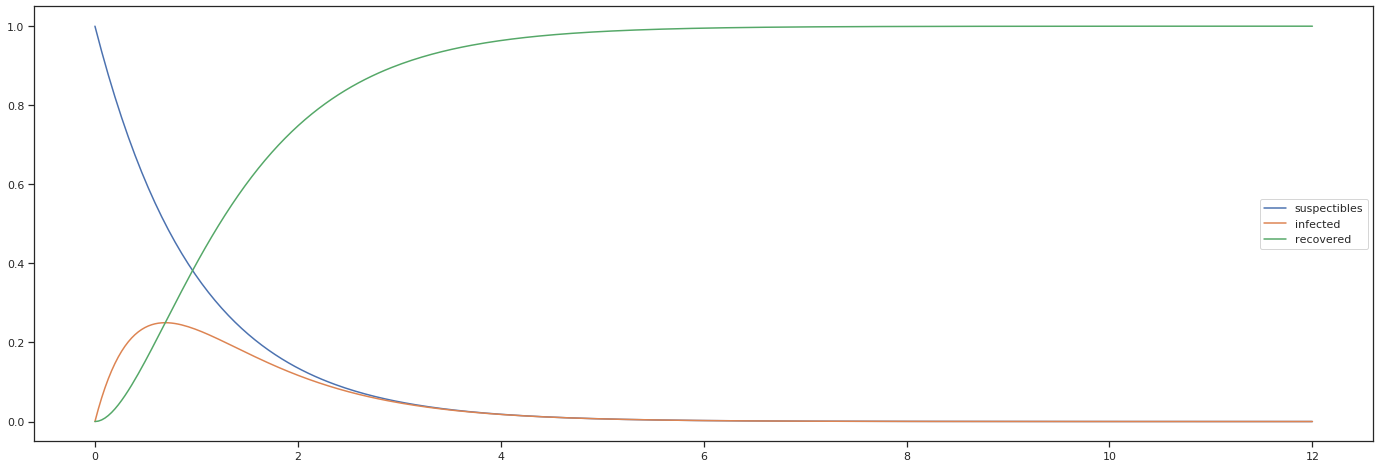

In [4]:
Gamma, Lambda = (2,1)
epidemic = pd.concat([pd.Series(suspectibles(t, Gamma, Lambda), index=t, name='suspectibles'),
                      pd.Series(infected(t, Gamma, Lambda), index=t, name='infected'),
                      pd.Series(recovered(t, Gamma, Lambda), index=t, name='recovered')
                     ], axis=1)
epidemic.plot(figsize=(24,8))

In [5]:
lambda_df = pd.concat([pd.DataFrame({'t':t,'infected':infected(t, Gamma, _), 'Lambda':_}) for _ in np.arange(0.1,2,0.2)])
lambda_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3660 entries, 0 to 365
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   t         3660 non-null   float64
 1   infected  3660 non-null   float64
 2   Lambda    3660 non-null   float64
dtypes: float64(3)
memory usage: 114.4 KB


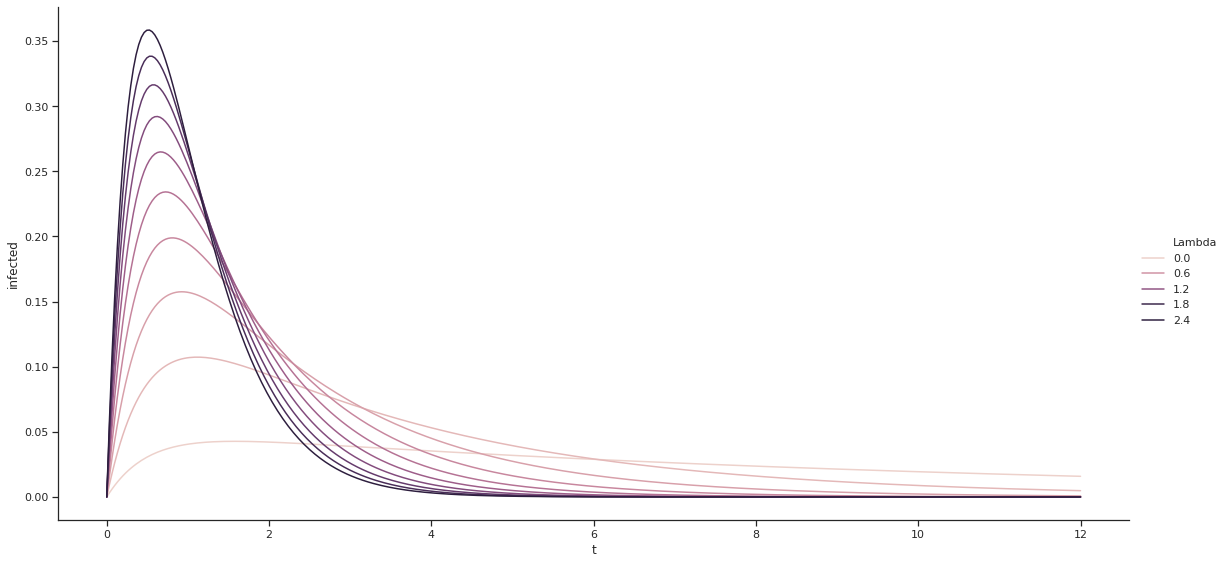

In [6]:
sns.relplot(x="t", y="infected",
            hue="Lambda",
            kind="line", data=lambda_df, 
            height=8, aspect=2);

# Numerical Solutions of the Time Dependent $\lambda$ SIR-Model

In [7]:
def sir(y, t, tau=14, R0=2.5):
    """
    Time Dependent $\lambda$ SIR-model
    tau: average illness period (15 days for COVID-19)
    R0:  base reproduction rate (2.5 for COVID-19)
    """
    Gamma = 1/tau
    Beta = Gamma * R0
    
    s, i, r = y
    dydt = [-Beta*i*s, 
            Beta*i*s - Gamma*i, 
            Gamma*i]
    return dydt

def nume_sir(tau, R0, horizon=365, with_plot=False):
    s0, r0 = 0.999, 0
    i0 = 1 -s0 -r0
    t = np.linspace(0,horizon,1+horizon)
    sol_df = pd.DataFrame(sp.integrate.odeint(sir, [s0, i0, r0], t, args=(tau, R0)),
                          columns=['poko malad', 'enfekte', 'retire'], 
                          index=t)
    if with_plot:
        ax=sol_df.plot(figsize=(8,8))
        fig = ax.get_figure()
        fig.savefig(f"../writeups/images/SIR_{str(R0)}_.png")
    sol_df['tau'] = round(tau,1)
    sol_df['R0'] = str(R0)
    return sol_df.reset_index().rename(columns={'index':'t'})

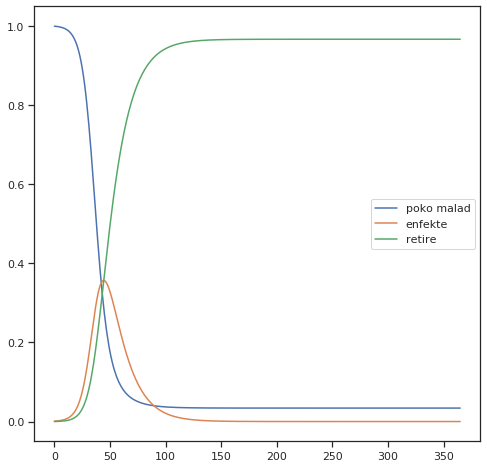

In [8]:
df = nume_sir(14,3.5, 365,with_plot=True)

In [9]:
study = pd.concat([nume_sir(tau,R0) for tau in np.linspace(14,24,5) for R0 in np.linspace(1.5, 3.5, 3)])

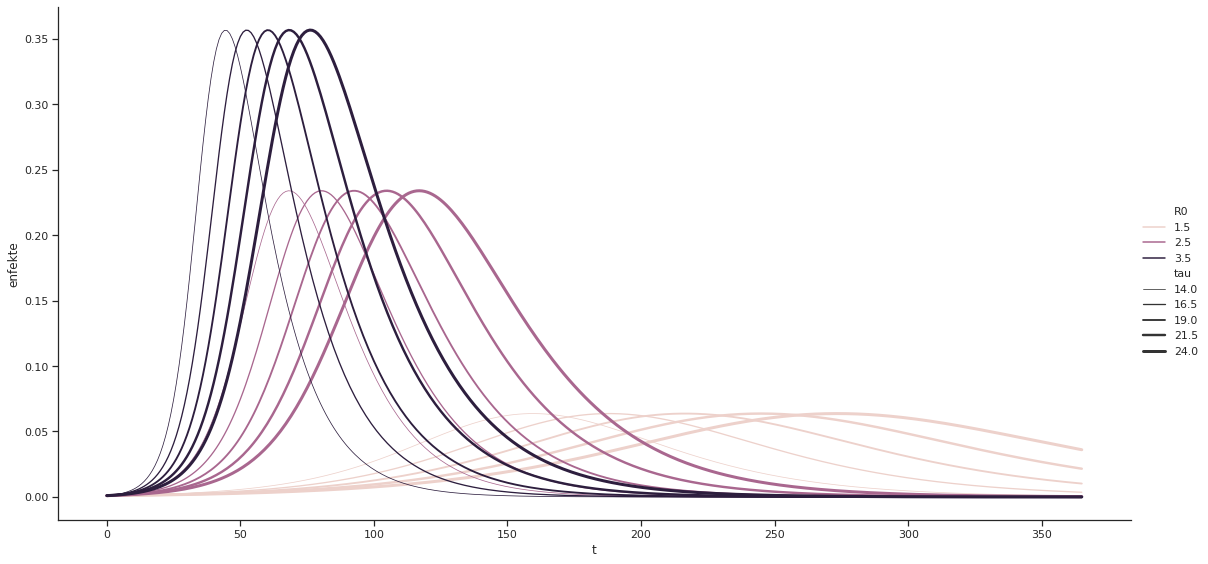

In [10]:
sns_plot = sns.relplot(x="t", y="enfekte",
            hue="R0", 
            size="tau",
            kind="line", data=study[['t','enfekte','tau','R0']], 
            height=8, aspect=2, legend="full");

In [11]:
sns_plot.savefig("../writeups/images/tau_r0.png")